In [1]:
import numpy as np
import pandas as pd
import paddle
from paddle import nn
from paddle.optimizer import Adam
from paddle.io import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import sqlite3

# 从数据库读取数据

In [2]:
# Connect to the SQLite database
connection = sqlite3.connect("./data/data203020/binance.db")

# Define the SQL query
sql_query = "SELECT * FROM BTCUSDT"

# Read data from the SQLite database into a pandas DataFrame
df = pd.read_sql_query(sql_query, connection)

# Close the database connection
connection.close()

# 修改数据结构

In [3]:
# 将字符串类型的数值列转换为浮点数
numeric_columns = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
df[numeric_columns] = df[numeric_columns].astype(float)

# 特征工程

In [4]:
# Calculate RSI
delta = df['close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

# Calculate EMA
ema_short = df['close'].ewm(span=12).mean()
ema_long = df['close'].ewm(span=26).mean()

# Calculate MACD
macd = ema_short - ema_long
signal_line = macd.ewm(span=9).mean()
histogram = macd - signal_line

# Add RSI, EMA, and MACD to the DataFrame
df['rsi'] = rsi
df['ema_short'] = ema_short
df['ema_long'] = ema_long
df['macd'] = macd
df['signal_line'] = signal_line
df['histogram'] = histogram

df['sma_3'] = df['close'].rolling(window=3).mean()
df['sma_6'] = df['close'].rolling(window=6).mean()
df['sma_12'] = df['close'].rolling(window=12).mean()
# 波动率
df['volatility_std'] = df['close'].rolling(window=5).std()
df['pct_change'] = df['close'].pct_change()
df['sma_20'] = df['close'].rolling(window=20).mean()
df['std_20'] = df['close'].rolling(window=20).std()
df['bollinger_upper'] = df['sma_20'] + 2 * df['std_20']
df['bollinger_middle'] = df['sma_20']
df['bollinger_lower'] = df['sma_20'] - 2 * df['std_20']
df['diff_bollinger_upper'] = df['close'] - df['bollinger_upper']
df['diff_bollinger_lower'] = df['close'] - df['bollinger_lower']
df['diff_sma_3'] = df['close'] - df['sma_3']
df['diff_sma_6'] = df['close'] - df['sma_6']
df['diff_sma_12'] = df['close'] - df['sma_12']

In [5]:
df.head()

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,...,sma_20,std_20,bollinger_upper,bollinger_middle,bollinger_lower,diff_bollinger_upper,diff_bollinger_lower,diff_sma_3,diff_sma_6,diff_sma_12
0,1504254000000,4716.47,4730.00,4716.47,4727.96,2.455540,1504254299999,11600.812852,32,1.659262,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1504254300000,4728.02,4762.99,4728.02,4762.99,1.969549,1504254599999,9375.300274,18,1.683266,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1504254600000,4731.12,4731.36,4731.12,4731.36,0.299831,1504254899999,1418.597288,3,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.410000,NaN,NaN
3,1504254900000,4750.00,4750.00,4746.63,4746.65,1.809314,1504255199999,8591.265774,13,0.983768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.350000,NaN,NaN
4,1504255200000,4746.65,4750.00,4746.65,4749.63,2.505225,1504255499999,11898.643549,22,1.041106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.083333,NaN,NaN


In [6]:
df.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'ignore', 'rsi', 'ema_short',
       'ema_long', 'macd', 'signal_line', 'histogram', 'sma_3', 'sma_6',
       'sma_12', 'volatility_std', 'pct_change', 'sma_20', 'std_20',
       'bollinger_upper', 'bollinger_middle', 'bollinger_lower',
       'diff_bollinger_upper', 'diff_bollinger_lower', 'diff_sma_3',
       'diff_sma_6', 'diff_sma_12'],
      dtype='object')

# 去除无用的字段`ignore`

In [7]:
data = df[['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'rsi', 'ema_short',
       'ema_long', 'macd', 'signal_line', 'histogram', 'sma_3', 'sma_6',
       'sma_12', 'volatility_std', 'pct_change', 'sma_20', 'std_20',
       'bollinger_upper', 'bollinger_middle', 'bollinger_lower',
       'diff_bollinger_upper', 'diff_bollinger_lower', 'diff_sma_3',
       'diff_sma_6', 'diff_sma_12']]

# 数据清洗
## 去除`nan`值

In [8]:
# 丢弃前20行含有nan的数据
data = data.iloc[20:]
data.reset_index(drop=True, inplace=True)

In [9]:
data.isna().sum()

open_time                       0
open                            0
high                            0
low                             0
close                           0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
rsi                             5
ema_short                       0
ema_long                        0
macd                            0
signal_line                     0
histogram                       0
sma_3                           0
sma_6                           0
sma_12                          0
volatility_std                  0
pct_change                      0
sma_20                          0
std_20                          0
bollinger_upper                 0
bollinger_middle                0
bollinger_lower                 0
diff_bollinger_upper            0
diff_bollinger_lower            0
diff_sma_3    

In [10]:
data = data.fillna(0)
data.isna().sum()

open_time                       0
open                            0
high                            0
low                             0
close                           0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
rsi                             0
ema_short                       0
ema_long                        0
macd                            0
signal_line                     0
histogram                       0
sma_3                           0
sma_6                           0
sma_12                          0
volatility_std                  0
pct_change                      0
sma_20                          0
std_20                          0
bollinger_upper                 0
bollinger_middle                0
bollinger_lower                 0
diff_bollinger_upper            0
diff_bollinger_lower            0
diff_sma_3    

# 数据分割，考虑时序数据的特征

### 数据分割需求
* 看了前n轮的数据预测n+1轮

In [11]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 创建滑动窗口
def create_sliding_window(data, window_size):
    x, y = [], []
    for i in range(len(data) - window_size-1):
        x.append(data[i:i+window_size, :])
        y.append(data[i+window_size+1, 1:5]) # 第1行、第5列是因为需要的是只有5个属性
    return np.array(x), np.array(y)

# 设定窗口大小（例如：30个时间步长）
window_size = 30

X, y = create_sliding_window(data_scaled, window_size)

# 数据划分
train_ratio = 0.8
train_size = int(len(X) * train_ratio)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:] 

# 将数据转换为PaddlePaddle所需的格式
X_train, y_train = paddle.to_tensor(X_train).astype('float32'), paddle.to_tensor(y_train).astype('float32')
X_test, y_test = paddle.to_tensor(X_test).astype('float32'), paddle.to_tensor(y_test).astype('float32')

W0417 19:55:26.273267   183 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 8.0, Driver API Version: 11.2, Runtime API Version: 11.2
W0417 19:55:26.277143   183 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.


# 构建模型结构

In [12]:
# 构建自定义模型
class CustomModel(nn.Layer):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomModel, self).__init__()

        self.bidirectional_lstm1 = nn.LSTM(input_size, hidden_size, direction="bidirectional")
        self.bidirectional_lstm2 = nn.LSTM(hidden_size * 2, hidden_size, direction="bidirectional")
        self.pooling = nn.AdaptiveAvgPool1D(1)
        self.unidirectional_lstm = nn.LSTM(hidden_size * 2, hidden_size, dropout=0.041)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.bidirectional_lstm1(x)
        x, _ = self.bidirectional_lstm2(x)
        x = self.pooling(x.transpose([0, 2, 1])).transpose([0, 2, 1])
        x, _ = self.unidirectional_lstm(x)
        x = self.fc(x[:, -1, :])
        return x

# 设置模型参数

In [13]:
# 模型参数设置
input_size = X_train.shape[2]
hidden_size = 166
output_size = 4

# 初始化模型、损失函数、优化器
model = CustomModel(input_size, hidden_size, output_size)
loss_fn = nn.MSELoss()
optimizer = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())

# 开始训练，并且保存模型
> 经过多次训练，模型在200轮后代价函数不再降低,选择训练到300轮停止训练

In [14]:
# 训练参数设置
epochs = 2000
batch_size = 512

import os

# 定义模型保存路径
model_save_dir = 'saved_models'
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

# 训练模型
for epoch in range(epochs):
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        loss.backward()
        optimizer.step()
        optimizer.clear_grad()
    print(f'Epoch {epoch + 1}, Loss: {loss.numpy()[0]}')
    # 每100轮保存一次模型
    if (epoch + 1) % 100 == 0:
        model_path = os.path.join(model_save_dir, f'epoch_{epoch + 1}_model.pdparams')
        paddle.save(model.state_dict(), model_path)
        print(f'Model saved at epoch {epoch + 1}: {model_path}')

Epoch 1, Loss: 0.013917500153183937
Epoch 2, Loss: 0.007578677032142878
Epoch 3, Loss: 0.005554632283747196
Epoch 4, Loss: 0.006158414296805859
Epoch 5, Loss: 0.005062250420451164
Epoch 6, Loss: 0.0033745437394827604
Epoch 7, Loss: 0.004534056875854731
Epoch 8, Loss: 0.003050408326089382
Epoch 9, Loss: 0.001996066654101014
Epoch 10, Loss: 0.0021589137613773346
Epoch 11, Loss: 0.009901448152959347
Epoch 12, Loss: 0.004975576885044575
Epoch 13, Loss: 0.00242301682010293
Epoch 14, Loss: 0.0020058010704815388
Epoch 15, Loss: 0.00039201564504764974
Epoch 16, Loss: 0.0012559951283037663
Epoch 17, Loss: 0.00062657764647156
Epoch 18, Loss: 0.0013172992039471865
Epoch 19, Loss: 0.0009823779109865427
Epoch 20, Loss: 0.0027249683625996113
Epoch 21, Loss: 0.003825429128482938
Epoch 22, Loss: 2.939553087344393e-05
Epoch 23, Loss: 0.004748356528580189
Epoch 24, Loss: 0.002671225694939494
Epoch 25, Loss: 0.0016802034806460142
Epoch 26, Loss: 0.0017891384195536375
Epoch 27, Loss: 0.0017868861323222518

KeyboardInterrupt: 

# 使用模型进行测试

In [15]:
# 加载模型
model = CustomModel(input_size, hidden_size, output_size)
model_state_dict = paddle.load('saved_models/epoch_400_model.pdparams')
model.load_dict(model_state_dict)
model.eval()

# 使用测试数据进行预测
# y_pred = model(X_test) 太大了GPU不够

batch_size = 512
n_batches = int(np.ceil(X_test.shape[0] / batch_size))
y_pred_list = []

for i in range(n_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, X_test.shape[0])
    X_test_batch = X_test[start_idx:end_idx]
    with paddle.no_grad():
        y_pred_batch = model(X_test_batch)
        y_pred_list.append(y_pred_batch.numpy())

y_pred_batch = model(X_test[0:30])
y_pred_batch.numpy()


# 将预测结果转换为Numpy数组
y_pred_np = np.concatenate(y_pred_list, axis=0)


# 反归一化预测结果
y_test_np = y_test.numpy()
temp_test = np.zeros((y_test_np.shape[0], data_scaled.shape[1]))
temp_pred = np.zeros((y_pred_np.shape[0], data_scaled.shape[1]))

temp_test[:, 1:5] = y_test_np
temp_pred[:, 1:5] = y_pred_np

y_test_unscaled = scaler.inverse_transform(temp_test)[:, 1:5]
y_pred_unscaled = scaler.inverse_transform(temp_pred)[:, 1:5]

# 计算评估指标（如：RMSE）
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
print(f'RMSE: {rmse}')


RMSE: 0.013676975853741169


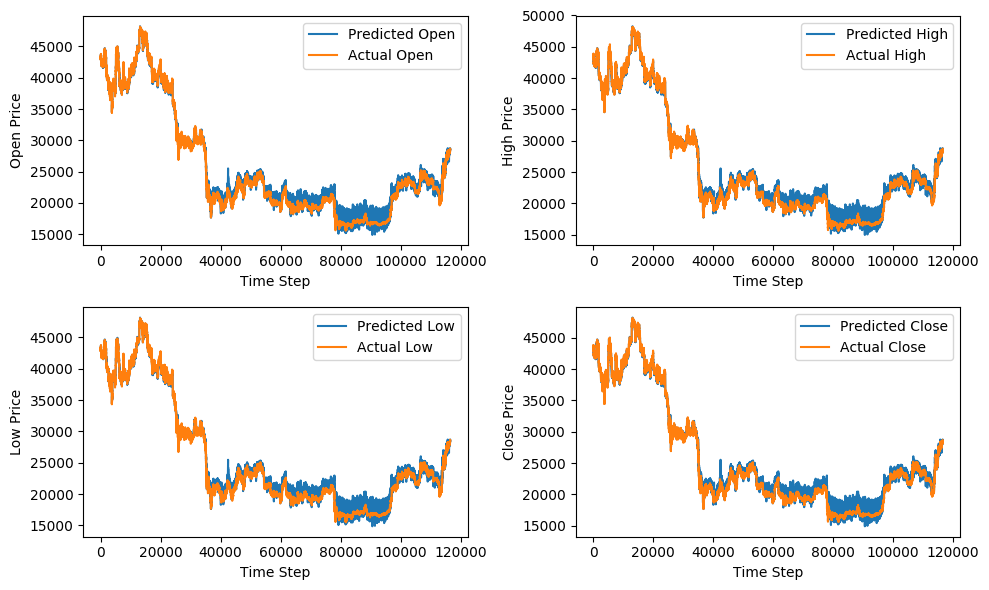

In [17]:
# 可视化预测结果
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

axes[0, 0].plot(y_pred_unscaled[:, 0], label='Predicted Open')
axes[0, 0].plot(y_test_unscaled[:, 0], label='Actual Open')
axes[0, 0].set_xlabel('Time Step')
axes[0, 0].set_ylabel('Open Price')
axes[0, 0].legend()

axes[0, 1].plot(y_pred_unscaled[:, 1], label='Predicted High')
axes[0, 1].plot(y_test_unscaled[:, 1], label='Actual High')
axes[0, 1].set_xlabel('Time Step')
axes[0, 1].set_ylabel('High Price')
axes[0, 1].legend()

axes[1, 0].plot(y_pred_unscaled[:, 2], label='Predicted Low')
axes[1, 0].plot(y_test_unscaled[:, 2], label='Actual Low')
axes[1, 0].set_xlabel('Time Step')
axes[1, 0].set_ylabel('Low Price')
axes[1, 0].legend()

axes[1, 1].plot(y_pred_unscaled[:, 3], label='Predicted Close')
axes[1, 1].plot(y_test_unscaled[:, 3], label='Actual Close')
axes[1, 1].set_xlabel('Time Step')
axes[1, 1].set_ylabel('Close Price')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# todo   
* [ ] 模型转化为生产   
* [ ] 接入实时数据

## 收盘价

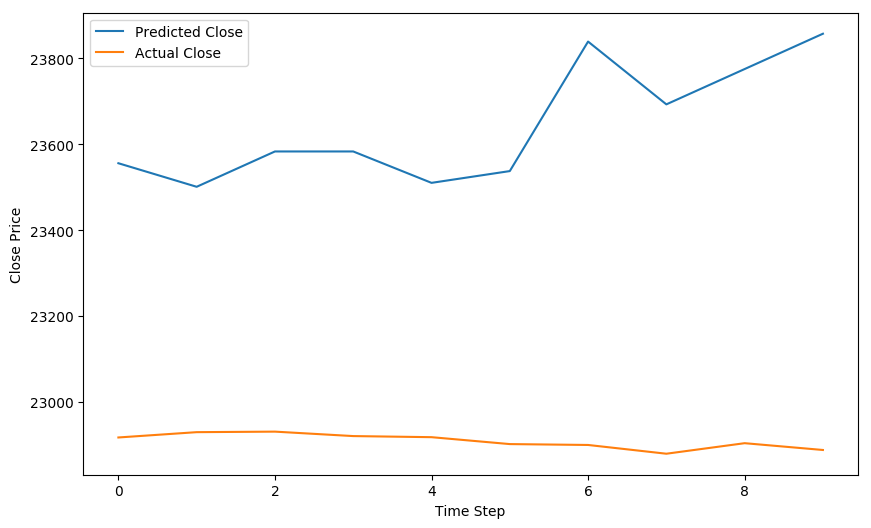

In [19]:
# 可视化预测结果（仅收盘价）
plt.figure(figsize=(10, 6))
plt.plot(y_pred_unscaled[100000:100010, 3], label='Predicted Close')
plt.plot(y_test_unscaled[100000:100010, 3], label='Actual Close')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()
